In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [ ]:
!pip install opendatasets

You should consider upgrading via the 'C:\Users\hp\anaconda3\python.exe -m pip install --upgrade pip' command.


### DATASET

In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/nadyanurfadhila/indonesia-endangered-animal2')

Skipping, found downloaded files in ".\indonesia-endangered-animal2" (use force=True to force download)


In [ ]:
#checking if the image all clear (no error)
#GAAK WAJIB GAUSA DI RUN KARNA DAH AMAN 
import os
from PIL import Image
folder_path = r'/content/Cleaned Endangered Animal/'
extensions = []
for fldr in os.listdir(folder_path):
    sub_folder_path = os.path.join(folder_path, fldr)
    for filee in os.listdir(sub_folder_path):
        file_path = os.path.join(sub_folder_path, filee)
        print('** Path: {}  **'.format(file_path), end="\r", flush=True)
        im = Image.open(file_path)
        rgb_im = im.convert('RGB')
        if filee.split('.')[1] not in extensions:
            extensions.append(filee.split('.')[1])

## SPLITTING FOLDER TRAIN VAL TEST

In [ ]:
pip install split-folders

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\hp\anaconda3\python.exe -m pip install --upgrade pip' command.


In [ ]:
import splitfolders
input_folder='./indonesia-endangered-animal2/Cleaned Endangered Animal/'

splitfolders.ratio(input_folder, output="output",
                   seed=42, ratio=(.8,.1,.1),
                  group_prefix=None)

Copying files: 751 files [00:05, 132.23 files/s]


Sample Beruang image:


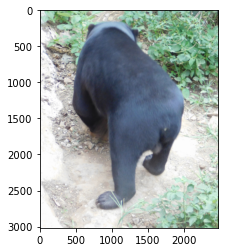

Sample Bekantan image:


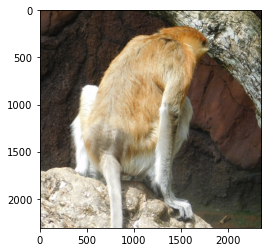

In [ ]:
train_dir = './output3/train'
val_dir = './output3/val'
test_dir = './output3/test'

print("Sample Beruang image:")
plt.imshow(load_img(f"{os.path.join('./output3/train/Beruang Madu', os.listdir('./output3/train/Beruang Madu')[1])}"))
plt.show()

print("Sample Bekantan image:")
plt.imshow(load_img(f"{os.path.join('./output3/train/Bekantan', os.listdir('./output3/train/Bekantan')[1])}"))
plt.show()

In [ ]:
#checking image size
# Load the first example of a horse
sample_image  = load_img(f"{os.path.join('./output3/train/Bekantan', os.listdir('./output3/train/Bekantan')[3])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (1977, 1549, 3)


## IMAGE AUGMENTATION

In [ ]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class 
  # Don't forget to normalize pixel values and set arguments to augment the images 
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=30,
                                   width_shift_range = 0.5,
                                   height_shift_range = 0.5,
                                   shear_range = 0.2,
                                   zoom_range = 0.7,
                                   fill_mode = 'nearest',
                                   horizontal_flip = True)

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=64, 
                                                      class_mode='categorical',
                                                      target_size= (224,224),
                                                      shuffle = True)

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  # Remember that validation data should not be augmented
  validation_datagen = ImageDataGenerator(rescale = 1./255)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=64, 
                                                                class_mode='categorical',
                                                                target_size=(224,224))

  # Pass in the appropriate arguments to the flow_from_directory method

  return train_generator, validation_generator

In [ ]:
train_generator, validation_generator = train_val_generators(train_dir, val_dir)

Found 598 images belonging to 6 classes.
Found 73 images belonging to 6 classes.


## RUNNING FIRST MODEL

In [ ]:
import tensorflow as tf
from tensorflow import keras
model = tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 128)      0

In [ ]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,
                    epochs=60,
                    steps_per_epoch=2,
                    validation_data=validation_generator,
                    verbose = 2,
                    validation_steps=2)

Epoch 1/60
2/2 - 33s - loss: 1.7906 - accuracy: 0.1797 - val_loss: 1.7772 - val_accuracy: 0.1781 - 33s/epoch - 17s/step
Epoch 2/60
2/2 - 28s - loss: 1.7907 - accuracy: 0.1719 - val_loss: 1.7683 - val_accuracy: 0.1918 - 28s/epoch - 14s/step
Epoch 3/60
2/2 - 25s - loss: 1.7771 - accuracy: 0.2266 - val_loss: 1.7631 - val_accuracy: 0.2055 - 25s/epoch - 13s/step
Epoch 4/60
2/2 - 25s - loss: 1.7794 - accuracy: 0.2266 - val_loss: 1.7579 - val_accuracy: 0.3151 - 25s/epoch - 13s/step
Epoch 5/60
2/2 - 19s - loss: 1.7519 - accuracy: 0.2674 - val_loss: 1.7522 - val_accuracy: 0.1918 - 19s/epoch - 10s/step
Epoch 6/60
2/2 - 31s - loss: 1.7556 - accuracy: 0.2422 - val_loss: 1.7483 - val_accuracy: 0.1918 - 31s/epoch - 16s/step
Epoch 7/60
2/2 - 30s - loss: 1.7692 - accuracy: 0.1719 - val_loss: 1.7478 - val_accuracy: 0.1918 - 30s/epoch - 15s/step
Epoch 8/60
2/2 - 26s - loss: 1.7437 - accuracy: 0.2109 - val_loss: 1.7433 - val_accuracy: 0.1918 - 26s/epoch - 13s/step
Epoch 9/60
2/2 - 26s - loss: 1.7441 - ac

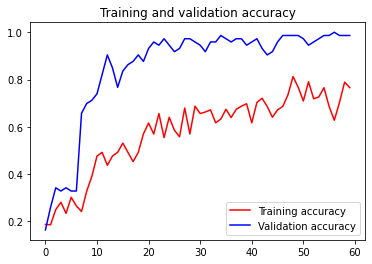

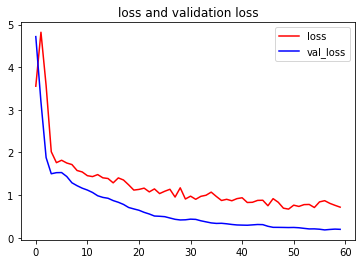

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.title('loss and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

### TRANSFER LEARNING

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [ ]:
def create_pre_trained_model(local_weights_file):

  pre_trained_model = InceptionV3(weights='imagenet', 
                              include_top=False, 
                              input_shape=(224,224, 3))

  #pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layers in pre_trained_model.layers:
    layers.trainable = False



  return pre_trained_model

In [ ]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_98 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_98[0][0]']              
 ormalization)                  )                                                      

## CALLBACK

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

## GET THE LAYER (MIXED4)

In [ ]:
def output_of_last_layer(pre_trained_model):

  last_desired_layer = pre_trained_model.get_layer('mixed4')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)
  

  return last_output

In [ ]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 12, 12, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 12, 12, 768), dtype=tf.float32, name=None), name='mixed4/concat:0', description="created by layer 'mixed4'")


In [ ]:
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


## ADDITION MODEL

In [ ]:
#def create_final_model(pre_trained_model ):
x = keras.layers.Flatten()(last_output)
x = keras.layers.Dense (256, activation='relu')(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense (6, activation='softmax')(x) 
model2 = Model(pre_trained_model.input, x)
model2.summary()

model2.compile(optimizer=keras.optimizers.Adam(0.0001),  # Low learning rate
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_98 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_98[0][0]']              
 ormalization)                  )                                                           

In [ ]:
callbacks = myCallback()
history = model2.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 80,
                    steps_per_epoch=2,
                    verbose = 2,
                    callbacks = [callbacks]
                    )

Epoch 1/80
2/2 - 32s - loss: 2.8024 - accuracy: 0.2266 - val_loss: 4.3250 - val_accuracy: 0.2192 - 32s/epoch - 16s/step
Epoch 2/80
2/2 - 27s - loss: 4.6634 - accuracy: 0.1797 - val_loss: 1.8579 - val_accuracy: 0.3973 - 27s/epoch - 13s/step
Epoch 3/80
2/2 - 27s - loss: 2.2568 - accuracy: 0.2578 - val_loss: 1.4984 - val_accuracy: 0.4247 - 27s/epoch - 13s/step
Epoch 4/80
2/2 - 25s - loss: 2.1458 - accuracy: 0.2500 - val_loss: 1.3472 - val_accuracy: 0.3425 - 25s/epoch - 13s/step
Epoch 5/80
2/2 - 24s - loss: 1.7540 - accuracy: 0.2812 - val_loss: 1.2270 - val_accuracy: 0.5890 - 24s/epoch - 12s/step
Epoch 6/80
2/2 - 23s - loss: 1.8043 - accuracy: 0.2812 - val_loss: 1.1642 - val_accuracy: 0.5479 - 23s/epoch - 12s/step
Epoch 7/80
2/2 - 19s - loss: 1.4311 - accuracy: 0.4535 - val_loss: 1.0783 - val_accuracy: 0.6575 - 19s/epoch - 9s/step
Epoch 8/80
2/2 - 23s - loss: 1.4487 - accuracy: 0.4766 - val_loss: 1.0544 - val_accuracy: 0.6712 - 23s/epoch - 11s/step
Epoch 9/80
2/2 - 23s - loss: 1.4247 - acc

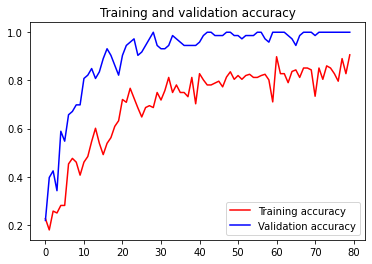

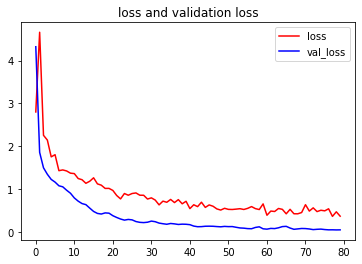

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.plot(epochs, loss, 'r', label='loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.title('loss and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
from tensorflow import keras
pre_trained_model.trainable = True
#model2.summary()

model2.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
                loss = keras.losses.CategoricalCrossentropy(from_logits=True),
                metrics = ['accuracy']
)

epochs = 5
model2.fit(train_generator,
           validation_data=validation_generator,
          epochs=epochs 
         )

Epoch 1/5


C:\Users\hp\anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


10/10 [==============================] - 263s 25s/step - loss: 0.4728 - accuracy: 0.8395 - val_loss: 0.0933 - val_accuracy: 0.9863
Epoch 2/5
10/10 [==============================] - 271s 27s/step - loss: 0.3854 - accuracy: 0.8763 - val_loss: 0.0687 - val_accuracy: 1.0000
Epoch 3/5
10/10 [==============================] - 251s 26s/step - loss: 0.4642 - accuracy: 0.8495 - val_loss: 0.0558 - val_accuracy: 1.0000
Epoch 4/5
10/10 [==============================] - 227s 22s/step - loss: 0.3866 - accuracy: 0.8746 - val_loss: 0.0637 - val_accuracy: 0.9863
Epoch 5/5
10/10 [==============================] - 264s 26s/step - loss: 0.3866 - accuracy: 0.8746 - val_loss: 0.0646 - val_accuracy: 0.9863


In [ ]:
import numpy as np
#from google.colab import files
from keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input
labels = train_generator.class_indices.keys()
#uploaded = files.upload()

#for paths in uploaded.keys():
 
  # predicting images
path = './download.jpg'
img = image.load_img(path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

images = np.vstack([x])
proba = model2.predict(images)[0]
maxx = proba.max()
plt.imshow(img)
plt.show()
for (label, p) in zip(labels, proba):
    print("{}: {:.2f}%".format(label, p * 100))
for (label, p) in zip(labels, proba):
    if p <= 0.4:
      continue
    elif p == maxx:
        if p<=0.4:
            continue
        elif p>= 0.5:
            print('\nResult: ')
            print(("{}: {:.2f}%".format(label, p* 100)))
        else:
            print('\nHewan ini tidak terdeteksi!')

In [ ]:
import pickle

In [ ]:
with open('sa-lindungi_pickle', 'wb') as f:
    pickle.dump(model,f)

INFO:tensorflow:Assets written to: ram://1e95d0e3-78f8-47ff-8006-f8f6cd61f48d/assets
